In [1]:
import cdsapi
import xarray as xr
import os
import zarr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import healpy as hp
import numpy as np

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
# Setting up a control flow for daily data for "pressure-level" data and in netcdf format.
# Define desired pressure levels and product types. A list of all available options can be 
# found at https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=download.
variables = ["specific_humidity"]
pressure_levels = ["300", "500", "800", "900", "975"]

# Define a timeframe where we will test the script and where the function will default to if no arguments are given.
year = ["2024"]
month = ["12"]
day = ["01", "02", "03", "04", "05"]
time = ["00:00", "06:00", "12:00","18:00"]


# Define where the data will be stored.
#path="era5_data/"
output_dir = "era5_data"

# Ordner erstellen, falls er noch nicht existiert
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Function for downloading the daily data, regridding the variables onto a healpix grid
# and saving the regridded data in a zarr storage.
def era5_daily_data(year,month,day,time):
    dataset = "reanalysis-era5-pressure-levels"
    client = cdsapi.Client()

    for years in year:
        for months in month:
            for days in day:
                name = os.path.join(output_dir, "era5_" + str(years) + str(months) + str(days) +".nc")
                # Check if file for a given day allready exists. It would be more elegant to check the zarr folder, but I could not implement it yet.
                if os.path.isfile(name) == True:
                    print("File " + name + " allready exists.")
                    continue
                # If not request data for that day.
                elif os.path.isfile(name) == False:
                    request = {
                        "product_type": ["reanalysis"],
                        "variable": variables,
                        "year": years,
                        "month": months,
                        "day": days,
                        "time": time,
                        "pressure_level": pressure_levels,
                        "data_format": "netcdf",
                        "download_format": "unarchived"
                        }
                    client.retrieve(dataset, request, name)
                    temp_data = xr.open_dataset(name)

                    # Interpolate the daily data tonto a healpix grid using https://healpix.sourceforge.io/html/intro_HEALPix_Software_Package.html.
                    # And save the regridded data as zarr.
                    nside = 8
                    dataset_hp = netcdf_to_healpix(temp_data, nside)
                    x_array_to_zarr(dataset_hp, nside)

                    # Nside could be implemented in a more flexible way.
                    nside = 16
                    dataset_hp = netcdf_to_healpix(temp_data, nside)
                    x_array_to_zarr(dataset_hp, nside)

In [4]:
# Function for creating healpix maps from a xarray dataset in geographical coordinates. Based on suggestions by ChatGpt.
# Returns a xarray dataset in pixel coordinates.
def netcdf_to_healpix(ds, nside):
    npix  = hp.nside2npix(nside)

    # Calulating the healpix pixel numbers from geographical coordinates, basically a coordinate transformation.
    # In theory only needs to be calculated once, but this way it might be possible to react to different geographical coordinates.
    lat = ds.latitude.values 
    lon = ds.longitude.values
    lat2d, lon2d = np.meshgrid(lat, lon, indexing="ij")
    theta = np.deg2rad(90.0 - lat2d)
    phi   = np.deg2rad(lon2d)
    pix = hp.ang2pix(nside, theta, phi)

    # Empty array to save the "pixelated" data.
    data_array_hp = np.empty(
        (ds.valid_time.size,
         ds.pressure_level.size,
         npix),
        dtype=np.float32
    )

    # remapping the variables from geographical coordinates to pixel coordinates for all pressure levels and time steps.
    # For now the coordinate here is hardcoded.
    for it in range(ds.valid_time.size):
        for ip in range(ds.pressure_level.size):
            data_array_hp[it, ip] = latlon_to_healpix(
                ds.q.isel(valid_time=it, pressure_level=ip).values,
                pix,
                npix
            )

    # New xarray dataset to store the healpix version.
    dataset_hp = xr.Dataset(
    {
        "q": (("valid_time", "pressure_level", "pixel"), data_array_hp)
    },
    coords={
        "valid_time": ds.valid_time,
        "pressure_level": ds.pressure_level,
        "pixel": np.arange(npix),
    },
    attrs={
        "healpix_nside": nside,
        "healpix_order": "RING",
    }
    )
    return(dataset_hp)

# Function for turning geographical lon lat coordinates to pixel coordinates. Based on suggestions by ChatGpt.
def latlon_to_healpix(field, pix, npix):
    """
    field: 2D np.ndarray (latitude, longitude)
    pix:   2D np.ndarray (latitude, longitude)
    """
    field_flat = field.ravel()
    pix_flat   = pix.ravel()

    hp_map = np.zeros(npix, dtype=np.float32)
    counts = np.zeros(npix, dtype=np.int32)

    valid = np.isfinite(field_flat)

    np.add.at(hp_map, pix_flat[valid], field_flat[valid])
    np.add.at(counts, pix_flat[valid], 1)

    hp_map[counts == 0] = np.nan
    hp_map[counts > 0] /= counts[counts > 0]

    return hp_map

# Function for saving the xarray dataset as zarr.
def x_array_to_zarr(dataset, nside):
    # Define chunking. Pixels is the only really large dimensions so it will get the largest chunks.Aa chunksize of 768 equals one chunk for nside = 8 
    # and 4 chunks for nside = 16 (nside=16: 12 * 16**2 / 768 = 4) 
    dataset = dataset.chunk(
    {
        "valid_time": 1,
        "pressure_level": 1,
        "pixel": 768  
    }
    )
    # Ive chosen the wrong saving mode. "w" overwrites the files while "a-" in combination with the "append_dim" parameters
    # define how to append data to zarr directories.
    output_file = os.path.join(output_dir, "era5_daily_data_" + str(nside) + ".zarr")
    
    dataset.to_zarr(
    output_file,
    mode="w",
    consolidated=True
    )

In [5]:
# Generate the daily data
era5_daily_data(year,month,day,time)

File era5_data/era5_20241201.nc allready exists.
File era5_data/era5_20241202.nc allready exists.
File era5_data/era5_20241203.nc allready exists.
File era5_data/era5_20241204.nc allready exists.
File era5_data/era5_20241205.nc allready exists.


In [19]:
#Open datasets for plotting
ds = xr.open_dataset(os.path.join(output_dir, "era5_20241205.nc"))
ds_hp = xr.open_zarr(os.path.join(output_dir, 'era5_daily_data_16.zarr'), consolidated=True)

Text(0.5, 0.98, 'Comparing the orignial netcdf data to the remapped healpix data.')

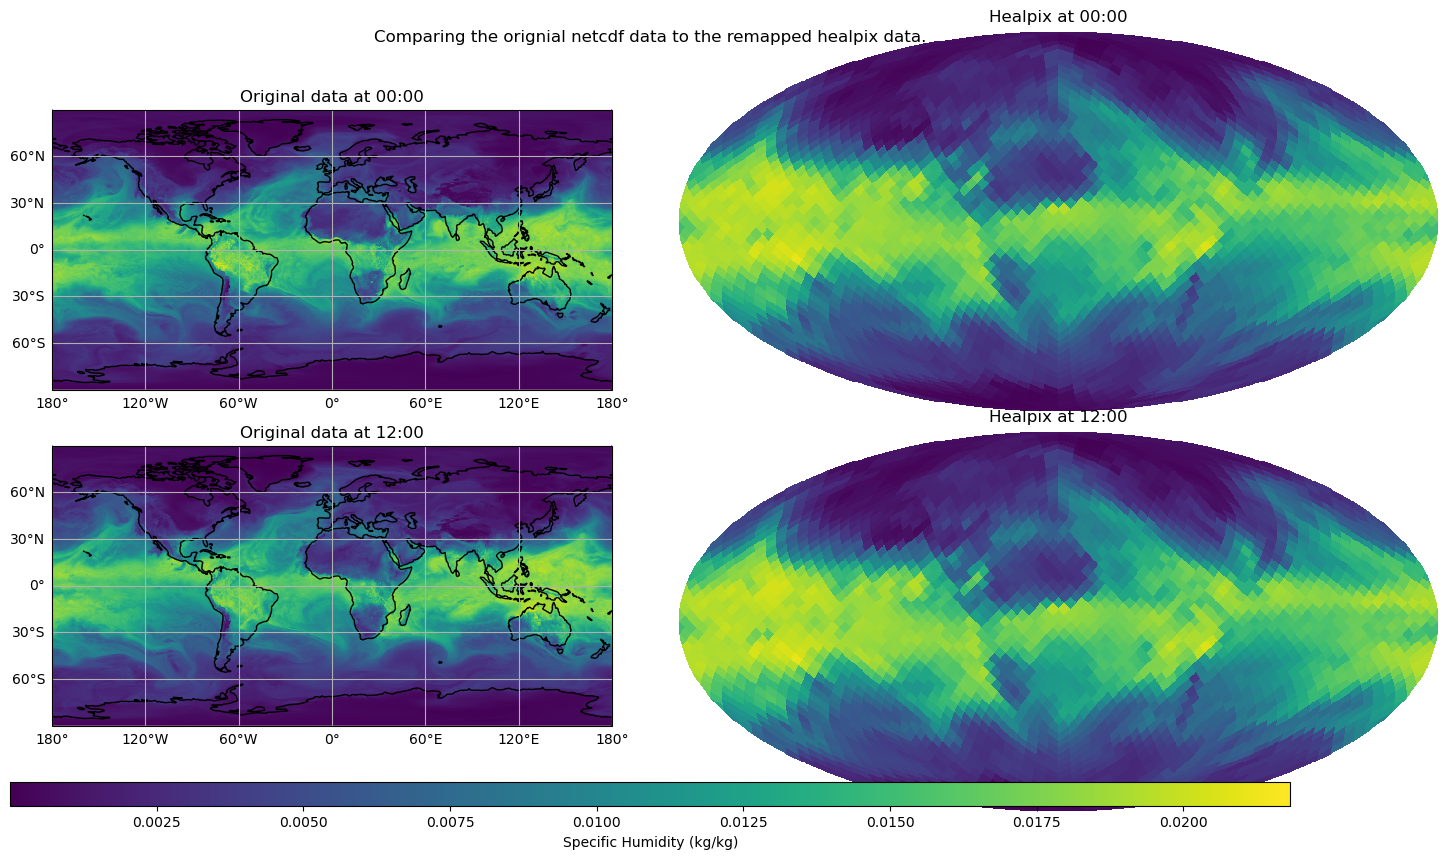

In [26]:
# Plots comparing the original and the regridded data

# Select data for pressure level 1000 hPa (index 0, since pressure_level[0] = 1000.0)
# and valid_time on Dezember 05, 2024 at 00:00 and at 12:00.
specific_humidity_data = ds['q'].sel(pressure_level = 975.0)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())


# Add gridlines and geographic coordiantes
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False
gl.right_labels=False
gm = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gm.top_labels=False
gm.right_labels=False

# Add coastlines to identify continents and oceans.
ax1.coastlines()
ax2.coastlines()

specific_humidity_night = specific_humidity_data.sel(valid_time=['2024-12-05T0:00:00']).plot(ax=ax1, add_colorbar=False)
specific_humidity_noon = specific_humidity_data.sel(valid_time=['2024-12-05T12:00:00']).plot(ax=ax2, add_colorbar=False)
hp.mollview(ds_hp.q.isel(valid_time=0, pressure_level=0).values, fig=fig.number, sub=(2,2,2), min=0.0, max=0.02, title="Healpix at 00:00", cbar=False,)
hp.mollview(ds_hp.q.isel(valid_time=0, pressure_level=0).values, fig=fig.number, sub=(2,2,4), min=0.0, max=0.02, title="Healpix at 12:00", cbar=False,)
# Beispiel: erste Zeit und erster Drucklevel

# The colorbar does not represent all subplots. Didnt have the time to implement due to time constraints. Only a comparison of the trends are useful.
cbar_ax = fig.add_axes([0.1, 0.01, 0.8, 0.03])
fig.colorbar(specific_humidity_night, cax=cbar_ax, orientation="horizontal", label="Specific Humidity (kg/kg)")

ax1.set_title("Original data at 00:00")
ax2.set_title("Original data at 12:00")
fig.suptitle('Comparing the orignial netcdf data to the remapped healpix data.')